In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur

In [35]:
mc = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Rapgap_nominal.pkl")

In [37]:
reco = mc[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()

In [43]:
pass_fiducial = np.array(mc['pass_fiducial'])

In [45]:
cuts_h1rpgp       = np.load('from_rapgap_cuts.npy')
q_perp_h1rpgp     = np.load('from_rapgap_q_perp.npy')

In [40]:
print(len(cuts_h1rpgp))

84183898


## Calculate $q_\perp$

In [39]:
e_px = reco[:,0]
e_py = reco[:,1]

jet_pT_mag = reco[:,3]
jet_phi = reco[:,5]

jet_qT = reco[:,7] #[not to be confused with q_Perp!]

print(min(jet_phi),max(jet_phi))
print(min(jet_pT_mag))

jet_px = np.multiply(jet_pT_mag, np.cos(jet_phi))
jet_py = np.multiply(jet_pT_mag, np.sin(jet_phi))

jet_pT = np.array([jet_px,jet_py])
e_pT = np.array([e_px,e_py])

q_perp_vec = jet_pT + e_pT
P_perp_vec = (e_pT-jet_pT)/2

q_perp_mag = np.linalg.norm(q_perp_vec,axis=0)
P_perp_mag = np.linalg.norm(P_perp_vec,axis=0)


q_dot_P = q_perp_vec[0,:]*P_perp_vec[0,:] + q_perp_vec[1,:]*P_perp_vec[1,:]

cosphi = (q_dot_P)/(q_perp_mag*P_perp_mag)
asymm_phi = np.arccos(cosphi)
#7.32459e-08 6.283185
print(np.shape(q_perp_mag))
print(np.shape(jet_phi))
print(np.shape(asymm_phi))

-9999.0 6.283185
-9999.0
(84183898,)
(84183898,)
(84183898,)


/tmp/ipykernel_26037/2058553828.py:28: RuntimeWarning: invalid value encountered in arccos
  asymm_phi = np.arccos(cosphi)


## Define Cuts

In [87]:
#pass_fiducial created under theta_G
pT_cut = jet_pT_mag > 10.
q_over_pT_cut = q_perp_mag/jet_pT_mag < 0.3 #Kyle guessed ~0.3, needs variation
qT_cut = np.where((jet_qT<0.25), True, False)
phi_nan_cut = ~np.isnan(asymm_phi)
#q_perp_cut = q_perp_mag < 10.0 #q_perp_max

print(np.shape(pT_cut))
#print(np.shape(q_perp_cut))


cut_arrays = [pass_fiducial,
              pT_cut,
              q_over_pT_cut,
              qT_cut,
              phi_nan_cut]
              #q_perp_cut]

cuts = np.ones(len(pT_cut))

for cut in cut_arrays:
    print(len(cut))
    cuts = np.logical_and(cuts,cut)
np.save("rapgap_reco_cuts.npy",cuts)

(84183898,)
84183898
84183898
84183898
84183898
84183898


In [46]:
truth_qT = q_perp_h1rpgp[cuts]
reco_qT = q_perp_mag[cuts]

look at the standard deviation of un-corrected q_T[reco] in bins of q_T-Truth

In [67]:
#Binning
N = 21
qT_Max = 10
qT_Bins = np.linspace(0,qT_Max,N)

Y_test = truth_qT
mypreds = reco_qT

#Goal: slices defined by bin of truthE, filled with prediction distributions
indecies = np.digitize(Y_test,qT_Bins)-1
max_count = ((np.bincount(indecies).max()))
slices = np.empty((N,max_count))
slices.fill(np.nan)

counter = np.zeros(N,int)
avg_truth = np.zeros(N,float)

pred_over_truth = np.zeros(N,float)

for i in range(len(mypreds)):
    
    #if (Y_test[i] > E_Max): continue
    bin = indecies[i]
    slices[bin][counter[bin]] = mypreds[i] #slices[bin, element inside bin]
    counter[bin]+=1
    avg_truth[bin]+=Y_test[i]
    pred_over_truth[bin] += mypreds[i]/Y_test[i]
    

#Resoluton: stdev(pred)/avg_truth    
avg_truth = avg_truth/counter
stdev_pred = np.nanstd(slices,axis=1)
resolution = stdev_pred

pred_over_truth = pred_over_truth/counter

<ErrorbarContainer object of 3 artists>

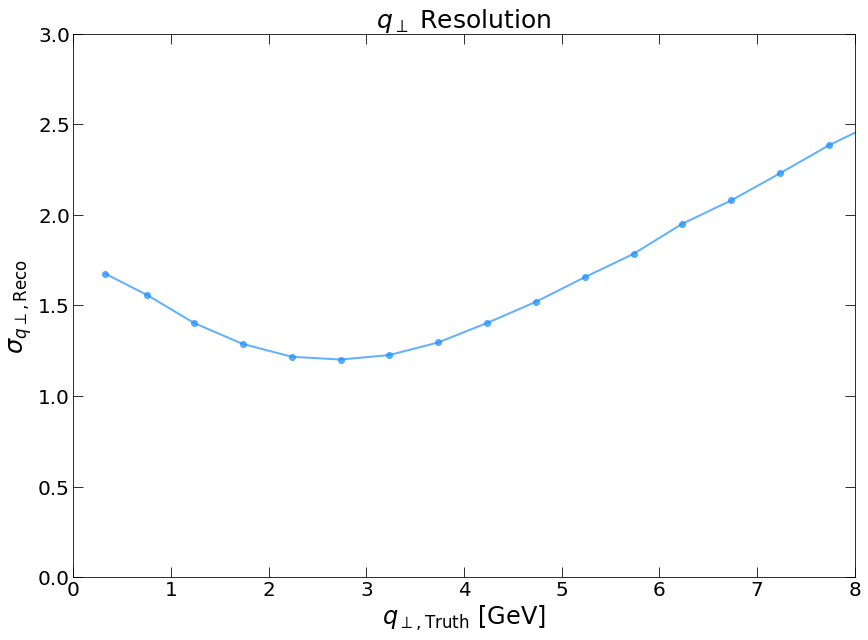

In [68]:
fig=plt.figure(figsize=(14,10))
plt.title("$q_\perp$ Resolution",fontsize=25)
plt.ylabel("$\sigma_{q\perp,\mathrm{Reco}}$",fontsize=24)
plt.xlabel("$q_{\perp,\mathrm{Truth}}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,8)
plt.ylim(0,3)
plt.tick_params(direction='in',right=True,top=True,length=10)

ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N

#errors = np.zeros(len(errors))
plt.errorbar(avg_truth[first_bin:last_bin],resolution[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='dodgerblue',alpha=0.7,label="PFN Deep Sets")
#_ = plt.text(0.7,0.93,"Stat. Error: $\dfrac{\sigma}{\sqrt{2N-2} } $",transform=ax.transAxes,fontsize=20)

#plt.legend(fontsize=22,loc="lower left")
#plt.savefig("%s/resolution_plot.pdf"%(path))

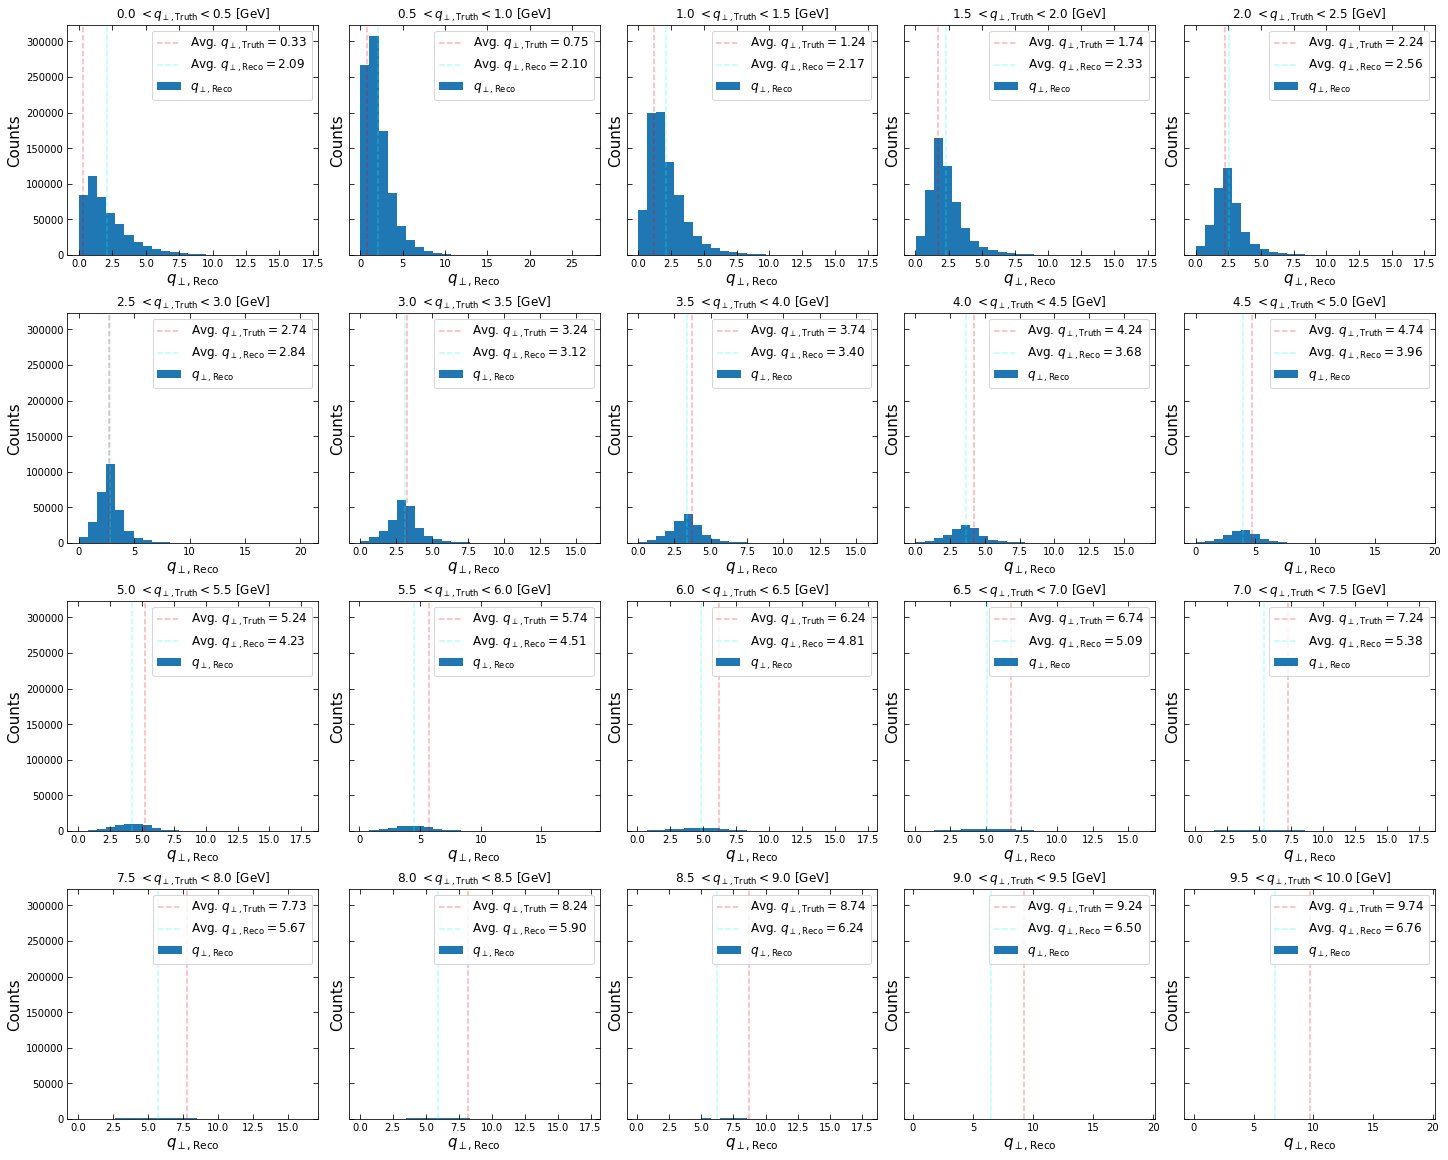

In [86]:
fig,axs = plt.subplots(int(N/5),5, figsize=(20, 16),sharex=False,sharey=True,constrained_layout=True)

for i,ax in enumerate(axs.ravel()):
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
        
    temp_bin = np.linspace(avg_truth[i]-2.0,avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < q_{\perp,\mathrm{Truth}} < $%1.1f [GeV]"%(qT_Bins[i],qT_Bins[i+1]))
    ax.set_xlabel("$q_{\perp,\mathrm{Reco}}$",fontsize=15)
    ax.hist(slices[i],label="$q_{\perp,\mathrm{Reco}}$",bins=25)
    ax.axvline(x=avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $q_{\perp,\mathrm{Truth}} = %1.2f$"%(avg_truth[i]))
    ax.axvline(x=np.nanmean(slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $q_{\perp,\mathrm{Reco}} = %1.2f$"%(np.nanmean(slices,axis=-1)[i]))

    ax.legend(fontsize=12)
    ax.tick_params(direction='in',right=True,top=True,length=5)
#plt.savefig("%s/resolutions_slices.pdf"%(path))